<!-- Notebook Header Start -->

<h1 align="center">Rat Trial DW333</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-11-29<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **Import Intan data in RHD format**
* **Package raw data into binary for Kilosort**
* **Run Kilosort to extract spike activity**
* **Calculate average firing rate of each cluster during a window of time.**

## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# 📈 Importing Libraries & Data
---

### imports

In [1]:
# standard imports
from pathlib import Path
import os
import pandas as pd
import numpy as np
from kilosort import io
import matplotlib.pyplot as plt

# custom imports
from automations import RM1
from automations import SpikeInterface_wrapper
from automations import Kilosort_wrapper
from automations import plots
from automations import analysis_functions

# I DON'T HAVE TO REDO THE ENTIRE ANALYSIS OMGGGGG
import importlib

# Make a change in von_frey_analysis.py ...

importlib.reload(plots)


<module 'automations.plots' from 'c:\\Users\\Karl\\Documents\\_Python\\CMU.49.003-Spike-Sorting-Kilosort\\automations\\plots.py'>

### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

In [2]:
# Path definitions

# save data to the inbox; make sure that the folders: binary & figures exist
SAVE_DIRECTORY = Path(r'D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.007 DRG Spikes during Von Frey\DW333')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.

# in this case, the data is saved in a folder with multiple rats
DATA_DIRECTORY = Path(r'D:\SynologyDrive\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.

# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)
PROBE_DIRECTORY = Path(r'D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.008 SpikeNeuro-Linear-32\SpikeNeuro-Linear-32.prb')

# 🔁 Identifying an experiment for initial analysis

This is used to determine which trial is most likely to produce good units in a spike sorting analysis

---

### importing the rat

In [3]:
DW333 = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, "DW333")

Reading qsttest_1_241115_150618...
Error reading stream 2 for qsttest_1_241115_150618. continuing...
Reading qsttest_1_241115_151239...
Error reading stream 2 for qsttest_1_241115_151239. continuing...
Reading qsttest_1_241115_151523...
Error reading stream 2 for qsttest_1_241115_151523. continuing...
Reading qst_1_241115_152031...
Error reading stream 2 for qst_1_241115_152031. continuing...
Reading qst_1_241115_152346...
Error reading stream 2 for qst_1_241115_152346. continuing...
Reading qst_1_241115_152800...
Error reading stream 2 for qst_1_241115_152800. continuing...
Reading VF_DRG_1_241115_145120...
Error reading stream 2 for VF_DRG_1_241115_145120. continuing...
Reading VF_DRG_1_241115_145435...
Error reading stream 2 for VF_DRG_1_241115_145435. continuing...
Reading VF_DRG_1_241115_145739...
Error reading stream 2 for VF_DRG_1_241115_145739. continuing...
Reading VF_DRG_4_241115_153512...
Error reading stream 2 for VF_DRG_4_241115_153512. continuing...
Reading VF_DRG_4_24111

In [4]:
DW333.qst_experiment_notes

'd1 is ttl, d2 am sync, a1 am monitor, a2 e von frey'

In [5]:
DW333.qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN
Trial Number,,,,,,,,,,
1,1,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"1 s every 10 s,",NaN
2,2,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
3,3,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
4,4,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
1,1,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
2,2,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
3,3,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
1,1,VF_hooks_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",lots of noise on the start... b0 is first hook...
2,2,VF_hooks_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",b0 is first hook. b1 is second


# Analysis

### filepath definitions

# 📈 Preprocess data using SpikeInterface

This is used to determine which trial is most likely to produce good units in a spike sorting analysis

---

### 📄 metadata

#### DW322

In [6]:
DW333.qst_experiment_notes

'd1 is ttl, d2 am sync, a1 am monitor, a2 e von frey'

In [7]:
DW333.qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN
Trial Number,,,,,,,,,,
1,1,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"1 s every 10 s,",NaN
2,2,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
3,3,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
4,4,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
1,1,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
2,2,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
3,3,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
1,1,VF_hooks_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",lots of noise on the start... b0 is first hook...
2,2,VF_hooks_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",b0 is first hook. b1 is second


#### DW323

In [8]:
DW333.qst_experiment_notes

'd1 is ttl, d2 am sync, a1 am monitor, a2 e von frey'

In [9]:
DW333.qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN
Trial Number,,,,,,,,,,
1,1,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"1 s every 10 s,",NaN
2,2,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
3,3,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
4,4,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
1,1,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
2,2,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
3,3,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
1,1,VF_hooks_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",lots of noise on the start... b0 is first hook...
2,2,VF_hooks_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",b0 is first hook. b1 is second


#### DW327

In [10]:
DW333.qst_experiment_notes

'd1 is ttl, d2 am sync, a1 am monitor, a2 e von frey'

In [11]:
DW333.qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN
Trial Number,,,,,,,,,,
1,1,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"1 s every 10 s,",NaN
2,2,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
3,3,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
4,4,VF_DRG_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",NaN
1,1,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
2,2,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
3,3,qst_,NaN,NaN,NaN,NaN,qst 52C,NaN,"5 s every 10 s,",hand held
1,1,VF_hooks_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",lots of noise on the start... b0 is first hook...
2,2,VF_hooks_,NaN,NaN,NaN,NaN,Von Frey,NaN,"5 s every 10 s,",b0 is first hook. b1 is second


### ↩ preprocess spinal cord data & export results to binary

⚠ !!this section is commented out, since I already have this done!!
I don't remove

preprocess

In [12]:
DW333.get_sc_data()
DW333.get_analog_data()
DW333.remove_drg_stim_window_sc()
DW333.remove_drg_stim_window_analog()

export to binary

DW333

In [13]:
signals_DW333 = SpikeInterface_wrapper(DW333, SAVE_DIRECTORY)
# trials = ["VF_1_240918_143256",
#           "VF_2_240918_143936",
#           "VF_3_240918_144658",
#           "VF_4_240918_145638",
#           "VF_5_240918_150137",
#           "VF_6_240918_150811",
#           "VF_7_240918_151516",
#           "VF_8_240918_152056",
#           "VF_9_240918_152753"]
# signals_DW322.save_spinalcord_data_to_binary(TRIAL_NAMES=trials)

Preparing SpikeInterface wrapper for rat DW333


# 🧠 Extract spikes with Kilosort4, import the results back into Python for analysis

⚠ !!this section is commented out, since I already have this done!!

---

In [14]:
def my_custom_criteria(cluster_labels, st, clu, est_contam_rate, fs):
    # Example criteria: Contamination rate < 0.1 and firing rate between 0.5 and 50 Hz
    contam_good = est_contam_rate < 0.2
    fr_good = np.zeros(cluster_labels.size, dtype=bool)
    for i, c in enumerate(cluster_labels):
        spikes = st[clu == c]
        fr = spikes.size / ((spikes.max() - spikes.min()) / fs)
        if 0.5 <= fr <= 50:
            fr_good[i] = True
    return np.logical_and(contam_good, fr_good)

In [15]:
### DW322
spikes_DW333 = Kilosort_wrapper(SAVE_DIRECTORY, PROBE_DIRECTORY)
# # Run Kilosort and apply custom labels with custom criteria
# spikes.run_kilosort_trial_summary(new_settings="vf_settings",custom_criteria=my_custom_criteria)

Preparing Kilosort wrapper...


extract results

(again, I've already run kilosort so I can skip right to extracting the results)

In [16]:
spikes_DW333.extract_kilosort_outputs()

Kilosort outputs successfully loaded for trial: qsttest_1_241115_150618
Kilosort outputs successfully loaded for trial: qsttest_1_241115_151239
Kilosort outputs successfully loaded for trial: qsttest_1_241115_151523
Kilosort outputs successfully loaded for trial: qst_1_241115_152031
Kilosort outputs successfully loaded for trial: qst_1_241115_152346
Kilosort outputs successfully loaded for trial: qst_1_241115_152800
Kilosort outputs successfully loaded for trial: VF_DRG_1_241115_145120
Kilosort outputs successfully loaded for trial: VF_DRG_1_241115_145435
Kilosort outputs successfully loaded for trial: VF_DRG_1_241115_145739
Kilosort outputs successfully loaded for trial: VF_DRG_4_241115_153512
Kilosort directory not found for trial: VF_DRG_4_241115_170440


In [17]:
spikes_DW333.kilosort_results

{'qsttest_1_241115_150618': {'ops': {'n_chan_bin': 32,
   'fs': 30000,
   'batch_size': 1500000,
   'nblocks': 0,
   'Th_universal': 9,
   'Th_learned': 8,
   'tmin': 0,
   'tmax': inf,
   'nt': 61,
   'shift': None,
   'scale': None,
   'artifact_threshold': inf,
   'nskip': 25,
   'whitening_range': 32,
   'highpass_cutoff': 300,
   'binning_depth': 5,
   'sig_interp': 20,
   'drift_smoothing': [0.5, 0.5, 0.5],
   'nt0min': 20,
   'dmin': 50.0,
   'dminx': 32,
   'min_template_size': 10,
   'template_sizes': 5,
   'nearest_chans': 10,
   'nearest_templates': 100,
   'max_channel_distance': 50.0,
   'templates_from_data': True,
   'n_templates': 6,
   'n_pcs': 6,
   'Th_single_ch': 6,
   'acg_threshold': 0.2,
   'ccg_threshold': 0.25,
   'cluster_downsampling': 20,
   'x_centers': None,
   'duplicate_spike_ms': 0.25,
   'data_dir': 'D:\\Data\\CMU.80 Data\\88 Analyzed Data\\88.007 DRG Spikes during Von Frey\\binary\\qsttest_1_241115_150618',
   'filename': 'D:\\Data\\CMU.80 Data\\88 An

##### explanation of output files
- **`ops`**: Loads the Kilosort options dictionary, which includes parameters and processing information.
- **`cluster_amplitudes` & `contamination_percentage`**: Load cluster amplitudes and contamination percentages from TSV files.
- **`channel_mapping`**: Loads the mapping of electrode channels.
- **`templates`**: Loads the spike waveform templates.
- **`chan_best`**: Identifies the best (most representative) channel for each template by finding the channel with the maximum energy (sum of squared amplitudes).
- **`amplitudes`**: Loads the amplitudes of detected spikes.
- **`spike_times`**: Loads spike times, typically in sample indices.
- **`spike_clusters`**: Loads cluster assignments for each spike.
- **`firing_rates`**: Calculates the firing rate for each unit (cluster) by counting the number of spikes and normalizing by the total recording time.
- **`dshift`**: Extracts the drift shift values from the options dictionary, which indicates the movement of the recording probe over time.

# 📊 Calculate firing rate per cluster - `DW333`

---

### steps
        1. Extracts Von Frey windows.
        2. Subdivides into sub-windows.
        3. Computes average voltage for each sub-window.
        4. Computes unit firing rates for each sub-window.
        5. Classifies sub-windows into 'pre-stim' (first 35s) and 'post-stim' (last 35s).
        6. calculates the Pearson correlation coefficient between von frey and inverse spike intervals (ISI)
        7. saves cluster firing rate, inverse ISI, and von frey data for each sub-window, and classification of "pre-stim" or "post-stim" to excel

In [18]:
VF_test = analysis_functions.VonFreyAnalysis(DW333, signals_DW333, spikes_DW333)


# VF_test.extract_von_frey_windows() # this works, but it also runs when I run the extract_cluster_firing_rates
# VF_test.compute_unit_firing_rates()
# VF_test.extract_von_frey_windows()
# Extract the main Von Frey windows
# intervals_dict = VF_test.extract_von_frey_windows()

# Subdivide the windows into smaller sub-windows of a chosen width (e.g., 0.5 seconds)
# subwindows_dict = VF_test.subdivide_intervals(VF_test.extract_von_frey_windows(), subwindow_width=0.5)

# Compute average voltage and unit firing rates for these smaller sub-windows
# The analyze_subwindows method internally calls subdivide_intervals, compute_average_von_frey_voltage, and compute_unit_firing_rates_for_subwindows
VF_test.analyze_subwindows(subwindow_width=0.5,corr_threshold=0.1)

# # to look at the results, you can use the dictionary keys like this:
# avg_voltage_df = results["VF_10_241125_162725"]["avg_voltage_df"]
# firing_rates_df = results["VF_10_241125_162725"]["firing_rates_df"]

[WARNING] Some spikes occur beyond the length of the Von Frey data. max spike time = 3324421, length of VF data = 2100000.
[WARNING] Some spikes occur beyond the length of the Von Frey data. max spike time = 3320536, length of VF data = 2100000.
[WARNING] Some spikes occur beyond the length of the Von Frey data. max spike time = 3317465, length of VF data = 2100000.
[WARNING] Some spikes occur beyond the length of the Von Frey data. max spike time = 3320442, length of VF data = 2100000.
[WARNING] Some spikes occur beyond the length of the Von Frey data. max spike time = 3322574, length of VF data = 2100000.
[WARNING] Some spikes occur beyond the length of the Von Frey data. max spike time = 3316460, length of VF data = 2100000.
[WARNING] Some spikes occur beyond the length of the Von Frey data. max spike time = 3326609, length of VF data = 2100000.
[WARNING] Some spikes occur beyond the length of the Von Frey data. max spike time = 3319509, length of VF data = 2100000.
[WARNING] Some s

{'qsttest_1_241115_150618': {'avg_voltage_df': Empty DataFrame
  Columns: [avg_voltage, group]
  Index: [],
  'firing_rates_df':                group        0         1         2         3         4  \
  correlation      NaN -0.00128 -0.001362  0.003251  0.003327  0.000028   
  is_correlated    NaN    False     False     False     False     False   
  
                        5         6         7         8        9       10  \
  correlation    0.004217 -0.012104  0.004145  0.017866  0.00102 -0.00118   
  is_correlated     False     False     False     False    False    False   
  
                       11        12        13        14       15        16  
  correlation   -0.000031 -0.006085  0.002063 -0.005478  0.01002  0.003788  
  is_correlated     False     False     False     False    False     False  },
 'qsttest_1_241115_151239': {'avg_voltage_df': Empty DataFrame
  Columns: [avg_voltage, group]
  Index: [],
  'firing_rates_df':                group         0         1         

In [19]:
# # if you want to look into the data, you can use the dictionary keys like this:
# avg_voltage_df = VF_test.windowed_results["VF_9_241125_162141"]["avg_voltage_df"]
# firing_rates_df = VF_test.windowed_results["VF_9_241125_162141"]["firing_rates_df"]

#### raster plot & von frey

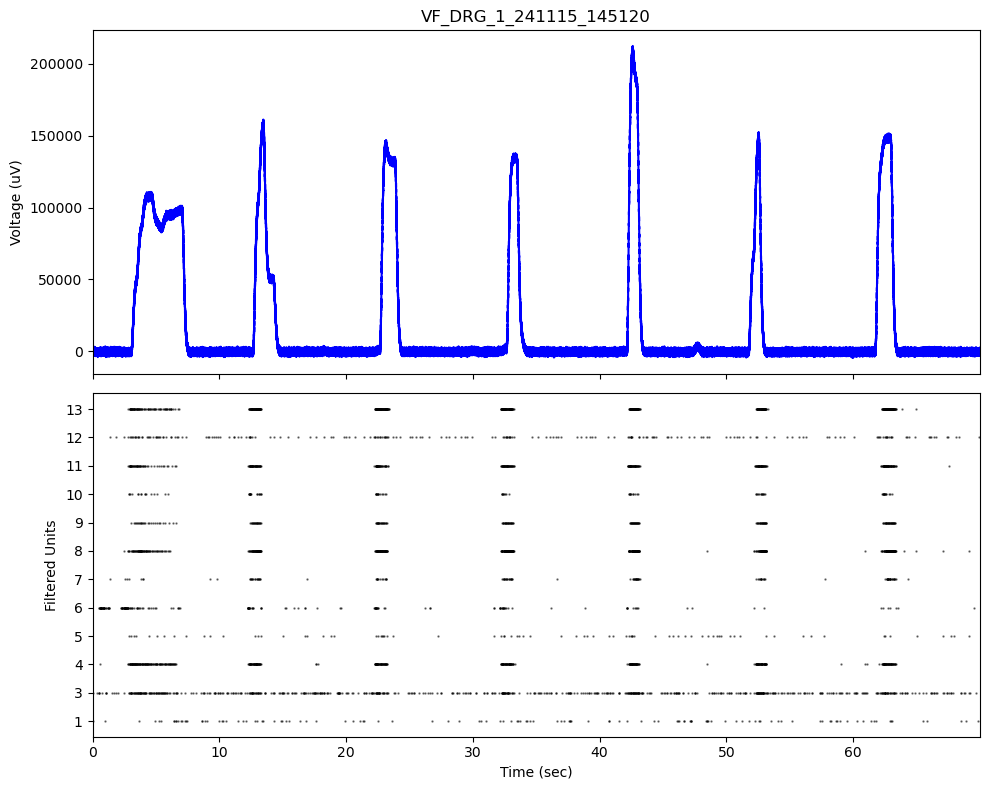

In [20]:
plots.plot_vf_spike_raster_filtered_units(VF_test, "VF_DRG_1_241115_145120",title="VF_DRG_1_241115_145120")

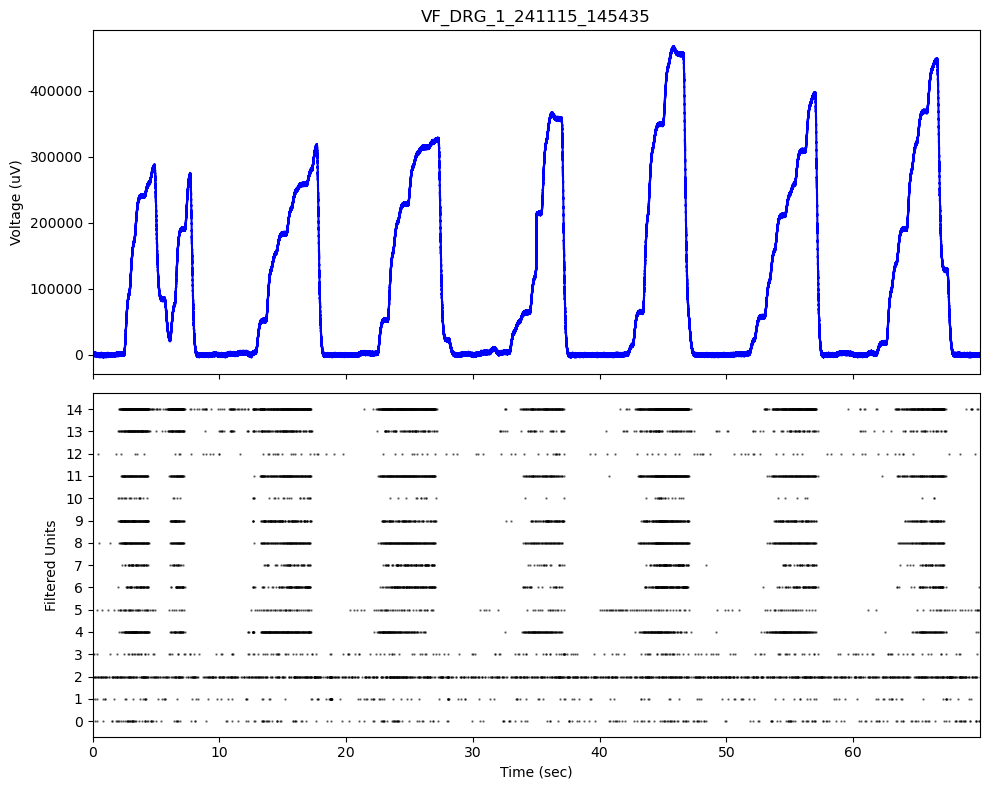

In [21]:
plots.plot_vf_spike_raster_filtered_units(VF_test, "VF_DRG_1_241115_145435",title="VF_DRG_1_241115_145435")

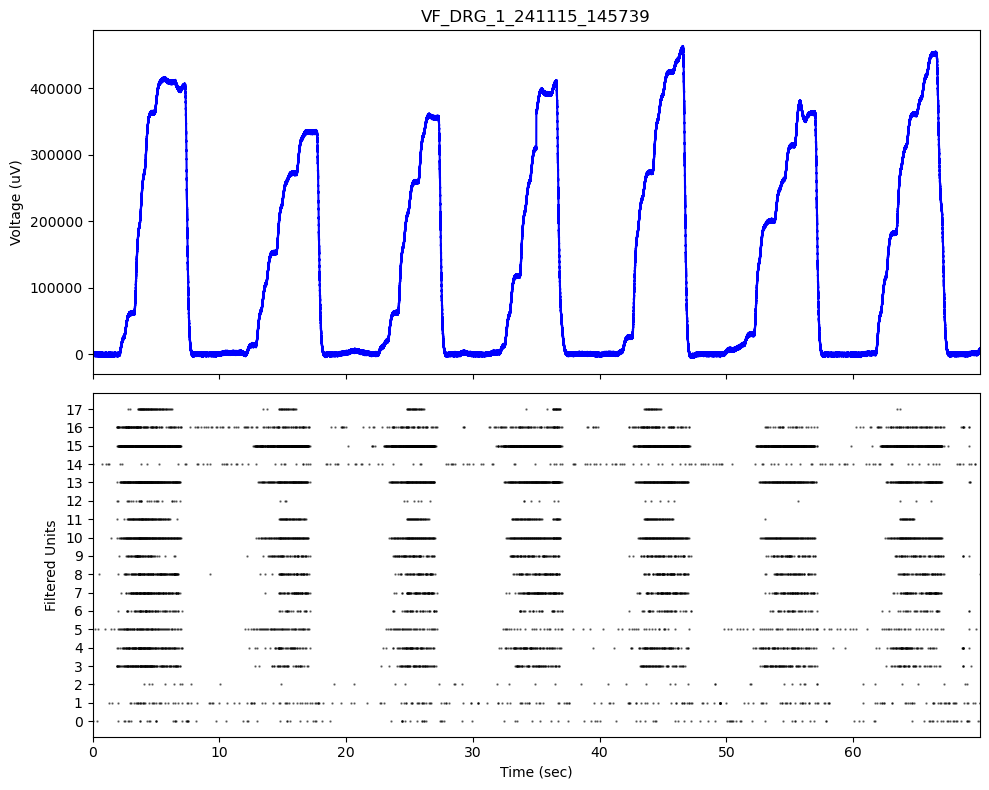

In [22]:
plots.plot_vf_spike_raster_filtered_units(VF_test, "VF_DRG_1_241115_145739",title="VF_DRG_1_241115_145739")

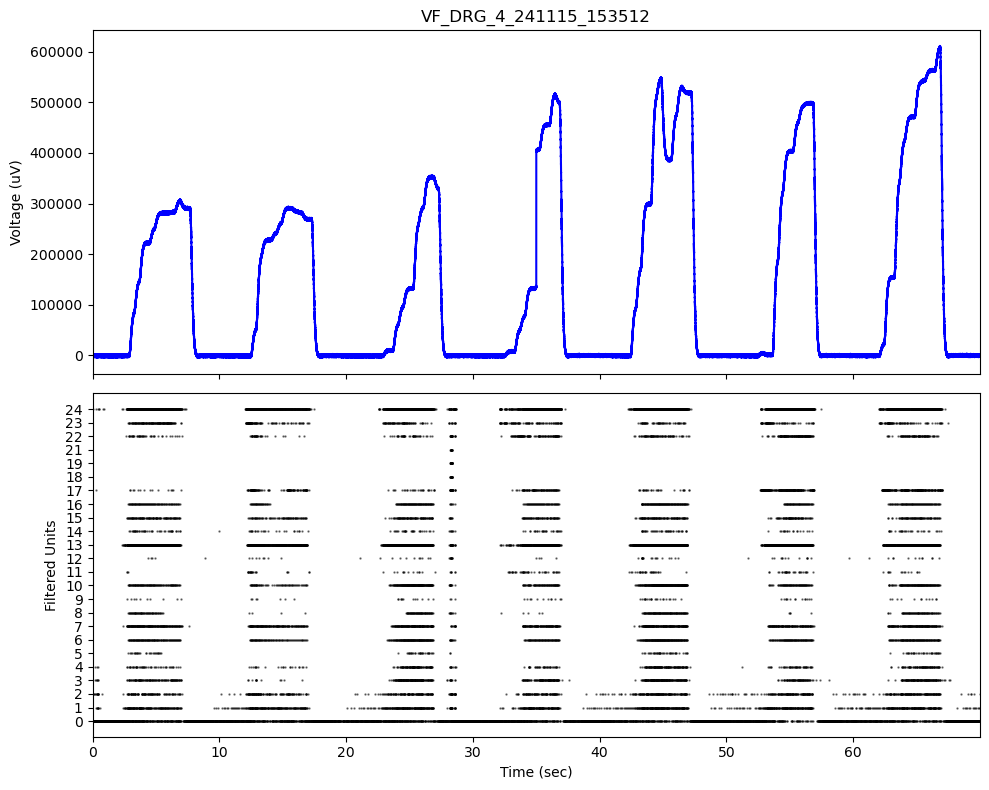

In [23]:
plots.plot_vf_spike_raster_filtered_units(VF_test, "VF_DRG_4_241115_153512",title="VF_DRG_4_241115_153512")

In [24]:
plots.plot_vf_spike_raster_filtered_units(VF_test, "VF_DRG_4_241115_170440",title="VF_DRG_4_241115_170440")

No kilosort results for trial 'VF_DRG_4_241115_170440'.


#### plots per trial

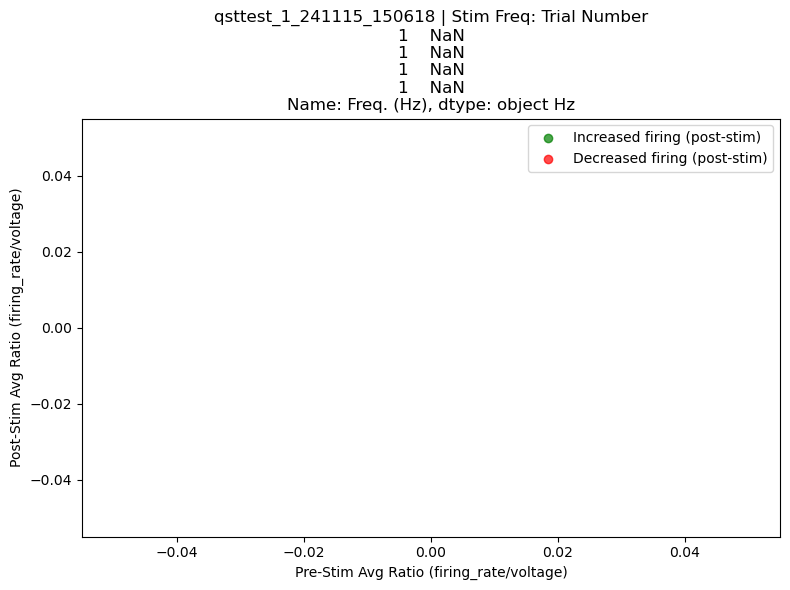

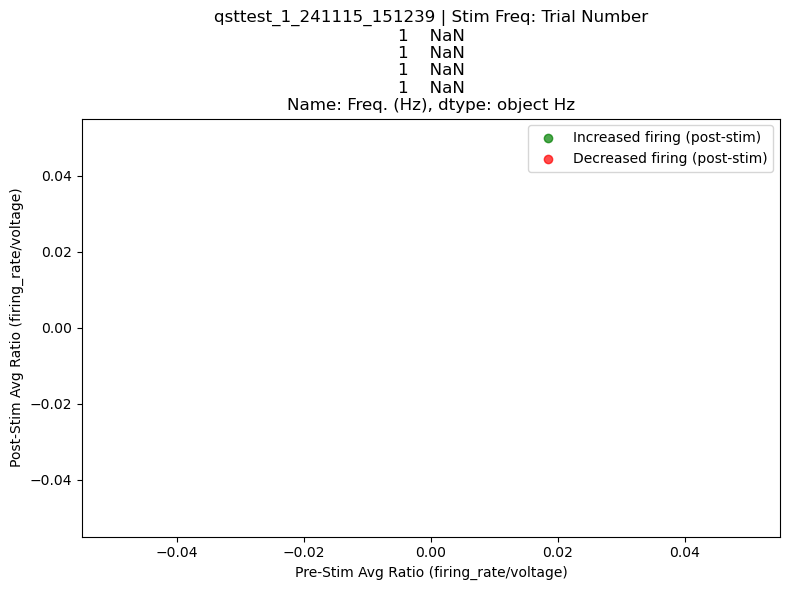

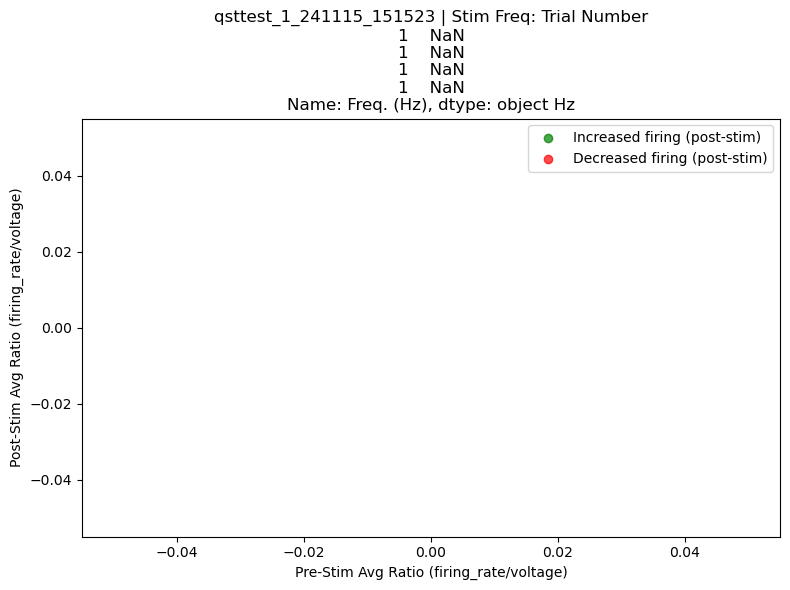

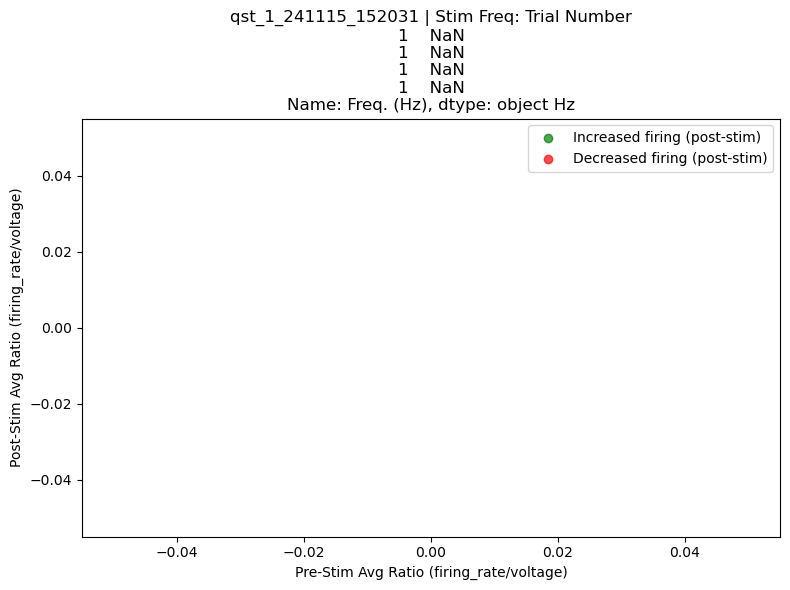

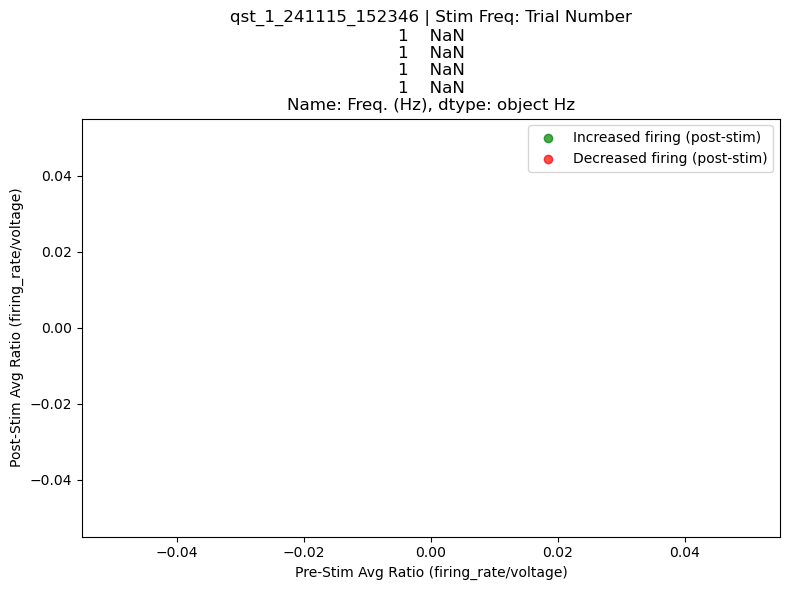

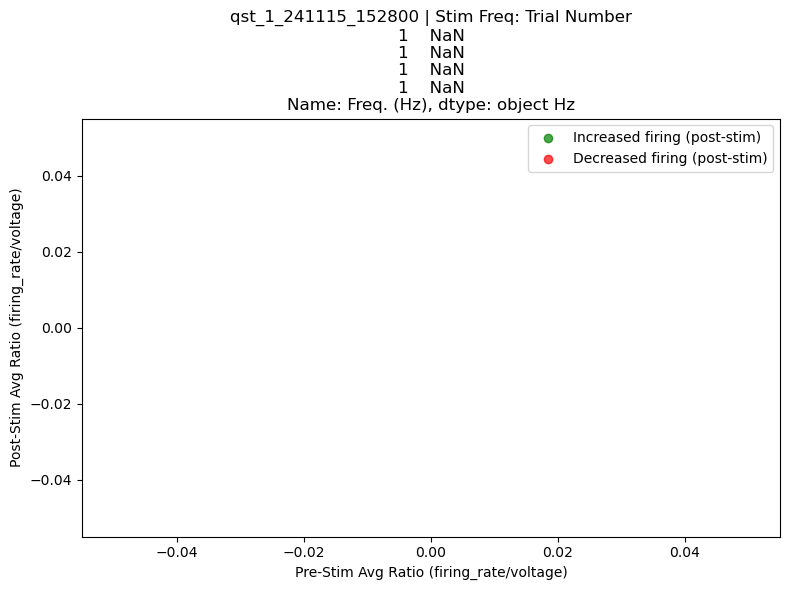

Unable to convert trial number to int from: DRG
Unable to convert trial number to int from: DRG
Unable to convert trial number to int from: DRG
Unable to convert trial number to int from: DRG


In [25]:
plots.vf_pre_post_stim_per_trial(VF_test)

#### plots - all trials in rat

In [26]:
plots.vf_pre_post_stim_all_trials_correlated(VF_test)

No clusters in trial 'qsttest_1_241115_150618' meet corr_threshold=0.1. Skipping.
No clusters in trial 'qsttest_1_241115_151239' meet corr_threshold=0.1. Skipping.
No clusters in trial 'qsttest_1_241115_151523' meet corr_threshold=0.1. Skipping.
No clusters in trial 'qst_1_241115_152031' meet corr_threshold=0.1. Skipping.
No clusters in trial 'qst_1_241115_152346' meet corr_threshold=0.1. Skipping.
No clusters in trial 'qst_1_241115_152800' meet corr_threshold=0.1. Skipping.
Unable to convert trial number to int from: DRG
Unable to convert trial number to int from: DRG
Unable to convert trial number to int from: DRG
Unable to convert trial number to int from: DRG
No valid data points to plot after correlation filtering.


# ⤵️ save data

In [27]:
signals_DW333.export_raw_spikes_and_von_frey_all_trials(spikes_DW333)

Spike data exported for trial qsttest_1_241115_150618 to D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.007 DRG Spikes during Von Frey\DW333\tables\qsttest_1_241115_150618_spikes.csv
Von Frey data exported for trial qsttest_1_241115_150618 to D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.007 DRG Spikes during Von Frey\DW333\tables\qsttest_1_241115_150618_von_frey.csv
Spike data exported for trial qsttest_1_241115_151239 to D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.007 DRG Spikes during Von Frey\DW333\tables\qsttest_1_241115_151239_spikes.csv
Von Frey data exported for trial qsttest_1_241115_151239 to D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.007 DRG Spikes during Von Frey\DW333\tables\qsttest_1_241115_151239_von_frey.csv
Spike data exported for trial qsttest_1_241115_151523 to D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.007 DRG Spikes during Von Frey\DW333\tables\qsttest_1_241115_151523_spikes.csv
Von Frey data exported for trial qsttest_1_241115_151523 to D:\Sy